In [6]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
import os

pd.set_option('display.min_rows', 10)
pd.set_option('display.max_rows', 10)

In [7]:
current_path = os.path.abspath("")
directory = os.path.dirname(current_path)
results_directory = rf"{directory}\bormhub_results"
weight_md_path = rf"{directory}\Notes\Fitness\Body weight.md" 
weight_df = pd.read_csv(weight_md_path, sep=",", header=None)
print(type(weight_df.loc[1,1]))

<class 'numpy.float64'>


In [8]:
weight_df[0] = pd.to_datetime(weight_df[0], format="%Y-%m-%d")
weight_df[1] = pd.to_numeric(weight_df[1], errors='coerce')
weight_df

,0,1
0,2025-02-06,82.4
1,2025-02-05,82.5
2,2025-02-04,81.9
3,2025-02-03,82.4
4,2025-02-02,82.1
...,...,...
174,2021-04-13,73.5
175,2021-04-06,74.0
176,2021-04-02,75.9
177,2021-03-25,76.9


In [9]:
def weight_at_date(date,weight_df):
    if date in weight_df[0]:
        bw = weight_df[1].values[date]
    else:
        earlier_dates = weight_df[0][weight_df[0] < date]
        later_dates = weight_df[0][weight_df[0] > date]
        nearest_earlier_date = max(earlier_dates)
        # check if latest lift is more recent than latest weight measurement
        # in which case, body weight is simply equal to last recorded weight
        if len(later_dates) == 0:
            earlier_row = weight_df.index.get_loc(weight_df[weight_df[0] == nearest_earlier_date].index[0])
            bw = weight_df.iloc[earlier_row,1]
        # if not, interpolate
        else:
            nearest_later_date = min(later_dates)

            earlier_row = weight_df.index.get_loc(weight_df[weight_df[0] == nearest_earlier_date].index[0])
            later_row = weight_df.index.get_loc(weight_df[weight_df[0] == nearest_later_date].index[0])
            earlier_weight = weight_df.iloc[earlier_row,1]
            later_weight = weight_df.iloc[later_row,1]
            # linear interpolation
            bw = earlier_weight + (date - nearest_earlier_date).total_seconds() * ((later_weight - earlier_weight)/(nearest_later_date - nearest_earlier_date).total_seconds())
    return bw

[('2023-10-08 12:00:00', '77.33632075471698'), ('2025-01-19 12:00:00', '82.35'), ('2024-09-30 12:00:00', '94.4')]


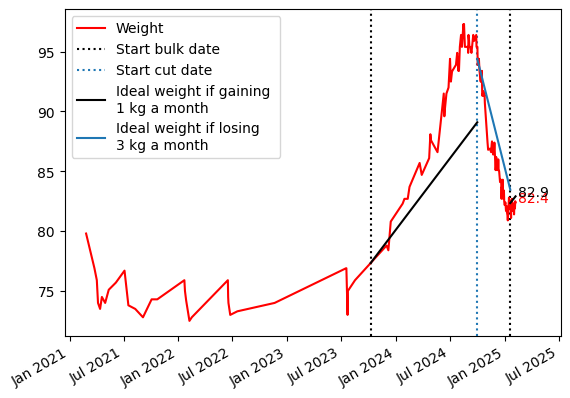

In [10]:
bulk_target = 1 # kg gained per month
cut_target = -3 # kg lost per month
# common wisdom is 0.5% of bodyweight lost per week, ~0.05*4.35*98 = 2.1 kg per month
cut_start_loss = -1 # kg lost immediately at beginning of cut
bulk_c = 'black'
cut_c = 'tab:blue'

bulk_date_strings = ['2023-10-8 12:00:00', '2025-01-19 12:00:00']
bulk_dates = []
for date_str in bulk_date_strings:
    date = pd.to_datetime(date_str)
    bulk_dates.append(date)
    plt.axvline(x=date, c=bulk_c, linestyle = ":")

cut_date_strings = ['2024-9-30 12:00:00']
cut_dates = []
for date_str in cut_date_strings:
    date = pd.to_datetime(date_str)
    cut_dates.append(date)
    plt.axvline(x=date, c=cut_c, linestyle = ":")

plt.plot(weight_df[0],weight_df[1],'r', label = "Weight")

bulk_start_weights = []
for date in bulk_dates:
    bw = weight_at_date(date,weight_df)
    bulk_start_weights.append(bw)

cut_start_weights = []
for date in cut_dates:
    bw = weight_at_date(date,weight_df)
    bw = bw + cut_start_loss
    cut_start_weights.append(bw)

recent_date = max(weight_df[0])
all_dates = bulk_dates + cut_dates + [recent_date]
print([ (str(x),str(y)) for x,y in zip(bulk_dates+cut_dates, bulk_start_weights+cut_start_weights)])

# plot ideal bulks 
for start_weight, date in zip(bulk_start_weights, bulk_dates):
    end_date = min( [ x for x in all_dates if x > date ] )
    bulk_ideal_weight = start_weight + (end_date - date).days/30.4375 * bulk_target
    plt.plot([date, end_date],[start_weight, bulk_ideal_weight], c=bulk_c)

# plot ideal cuts
for start_weight, date in zip(cut_start_weights, cut_dates):
    end_date = min( [ x for x in all_dates if x > date ] )
    cut_ideal_weight = start_weight + (end_date - date).days/30.4375 * cut_target
    plt.plot([date, end_date],[start_weight, cut_ideal_weight], c=cut_c)

# check if currently bulk or cut
if max(bulk_dates) > max(cut_dates):
    ideal_weight = bulk_ideal_weight
else:
    ideal_weight = cut_ideal_weight

date_margin = (recent_date - min(all_dates))* 0.02 # annotate 2% to right of line
plt.annotate(f"{weight_df[1][0]:.1f}", (recent_date + pd.Timedelta(date_margin, unit="d"), weight_df[1][0]) , c="r")
plt.annotate(f"{ideal_weight:.1f}", (recent_date + pd.Timedelta(date_margin, unit="d"), ideal_weight) )

xlim = plt.gca().get_xlim()
# expand x limits to 5% further on RHS
plt.xlim( xlim[0], xlim[1]+(xlim[1]-xlim[0])*0.05 )

# dummy labels
plt.plot([], [], c=bulk_c, linestyle = ":", label = "Start bulk date")
plt.plot([], [], c=cut_c, linestyle = ":", label = "Start cut date")
plt.plot([], [], c=bulk_c, label = f"Ideal weight if gaining \n{bulk_target} kg a month")
plt.plot([], [], c=cut_c, label = f"Ideal weight if losing \n{-cut_target} kg a month")
plt.legend()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()

plt.savefig(rf'{results_directory}\figures\weight.png', dpi=300, bbox_inches='tight')